![alt text](./Cerny_logo_1.jpg)

# Analysis of Cerny ventilation recordings

#### Manual revision and trimming of ventilator recordings.

This notebook imports the preprocessed **Fabian ventilator parameters** data from pickle archive and performs trimming based on manual inspection of data.

The data processed and analysed in this Notebook were collected by the **Neonatal Emergency and Transport Service of the Peter Cerny Foundation**, Budapest, Hungary

**Author: Dr Gusztav Belteki**

### 1. Import the required libraries and set options

In [1]:
import IPython
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

import os
import sys
import pickle

from pandas import Series, DataFrame
from datetime import datetime, timedelta
from matplotlib import dates

%matplotlib inline
matplotlib.style.use('classic')
matplotlib.rcParams['figure.facecolor'] = 'w'

pd.set_option('display.max_rows', 300)
pd.set_option('display.max_columns', 300)
# pd.set_option('mode.chained_assignment', None) 

import warnings
warnings.simplefilter("ignore")

In [2]:
print("Python version: {}".format(sys.version))
print("pandas version: {}".format(pd.__version__))
print("matplotlib version: {}".format(matplotlib.__version__))
print("NumPy version: {}".format(np.__version__))
print("IPython version: {}".format(IPython.__version__))

Python version: 3.11.7 (main, Dec 15 2023, 12:09:04) [Clang 14.0.6 ]
pandas version: 2.1.4
matplotlib version: 3.8.0
NumPy version: 1.26.3
IPython version: 8.20.0


### 2. List and set the working directory and the directory to write out data

In [3]:
# Name of the external hard drive
DRIVE = 'GUSZTI'

# Directory on external drive to read the clinical from
DIR_READ = os.path.join(os.sep, 'Volumes', DRIVE, 'Fabian_new', 'fabian_patient_data_all_new')

# Path to project folder containing ventilation research results
PATH = os.path.join(os.sep, 'Users', 'guszti', 'Library', 'Mobile Documents', 'com~apple~CloudDocs', 
                            'Documents', 'Research', 'Ventilation')

# Folder to export the result of analysis
DIR_WRITE = os.path.join(PATH, 'ventilation_fabian_new', 'Analyses')
os.makedirs(DIR_WRITE, exist_ok = True)

# Folder on a USB stick to export data to and to import processed data exported by other Notebooks
DATA_DUMP = os.path.join(os.sep, '/Volumes', DRIVE, 'data_dump', 'fabian_new',)
os.makedirs(DATA_DUMP, exist_ok = True)

In [4]:
DIR_READ, DIR_WRITE, DATA_DUMP

('/Volumes/GUSZTI/Fabian_new/fabian_patient_data_all_new',
 '/Users/guszti/Library/Mobile Documents/com~apple~CloudDocs/Documents/Research/Ventilation/ventilation_fabian_new/Analyses',
 '/Volumes/GUSZTI/data_dump/fabian_new')

### 3. Import pickle archives

In [5]:
with open(os.path.join(DATA_DUMP, 'clin_df_new.pickle'), 'rb') as handle:
    clin_df = pickle.load(handle)

with open(os.path.join(DATA_DUMP, 'data_pars_measurements_new_1_1305.pickle'), 'rb') as handle:
    data_pars_measurements = pickle.load(handle)
    
with open(os.path.join(DATA_DUMP, 'data_pars_settings_new_1_1305.pickle'), 'rb') as handle:
    data_pars_settings = pickle.load(handle)
    
with open(os.path.join(DATA_DUMP, 'data_pars_alarms_new_1_1305.pickle'), 'rb') as handle:
    data_pars_alarms = pickle.load(handle)

In [6]:
len(data_pars_measurements)

1015

In [7]:
cases = sorted(data_pars_measurements.keys())

In [8]:
# Import DataFrame with ventilation modes before trimming

with open(os.path.join(DATA_DUMP, 'vent_modes_unedited_new_1_1305.pickle'), 'rb') as handle:
    vent_modes_unedited = pickle.load(handle)

len(vent_modes_unedited)

1015

### 4. Remove some abnormal recordings 

In [9]:
# Remove recordings do not actually contain periods with the patient connected
to_remove = []

for case in to_remove:
    if case in cases:
        cases.remove(case)

### 5. Remove the periods from the beginning and the end of the recordings when the patient was not connected to the ventilator

This requires manual inspection of the tidal volume and pressure graphs

This dictionary contains tuples of the start and end points as strings
This was obtained by manual inspection of VTmand and PIP and the recordings
and manually removing the start and the end when the baby was not on the ventilator (e.g. no VTmand)

In [383]:
with open(os.path.join(DATA_DUMP, 'limit_new_1_1305.pickle'), 'rb') as handle:
    limit = pickle.load(handle)

In [384]:
len(limit)

1015

In [385]:
print(sorted(set(cases) - set(limit)))

[]


In [327]:
cases;

In [380]:
case = sorted(set(cases) - set(limit))[0]

index = cases.index(case)
index

IndexError: list index out of range

In [366]:
vent_modes_unedited.loc[case]

Ventilator_mode
CPAP              0.0
DUOPAP            0.0
HFO               0.0
IPPV              0.0
NCPAP             0.0
O2therapy         0.0
PSV               0.0
SIMV           4066.0
SIMVPSV           0.0
SIPPV             0.0
ventilation    4066.0
noninvasive       0.0
total          4066.0
VG             3642.0
Name: AT001305, dtype: float64

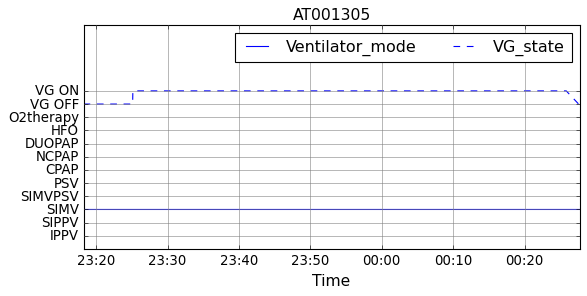

In [367]:
mapping_vent_mode = {1: 'IPPV', 2: 'SIPPV', 3: 'SIMV', 4: 'SIMVPSV', 5: 'PSV', 
                     6: 'CPAP', 7: 'NCPAP', 8: 'DUOPAP', 9: 'HFO', 10: 'O2therapy'}
mapping_vent_mode_rev = {value:key for key, value in mapping_vent_mode.items()}
mapping_vent_mode_rev

mapping_VG = {11: 'off', 12: 'on'}
mapping_VG_rev = {value:key for key, value in mapping_VG.items()}
mapping_VG_rev

par1 = 'Ventilator_mode'
par2 = 'VG_state'
dim = 'cmH$_2$O'

yticks = np.arange(1, 13)
yticklabels = ['IPPV', 'SIPPV','SIMV','SIMVPSV', 'PSV', 'CPAP', 'NCPAP', 'DUOPAP', 'HFO', 'O2therapy',
              'VG OFF', 'VG ON']

fig = plt.figure()
fig.set_size_inches(8, 4)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
ax = fig.add_subplot(1, 1, 1)
        
data = data_pars_settings[case][par1].replace(mapping_vent_mode_rev)
data.plot(ax = ax, label = par1, color='blue', x_compat = True)
        
data_2 = data_pars_settings[case][par2].replace(mapping_VG_rev)
data_2.plot(ax = ax, label = par2, color='blue', linestyle='dashed', x_compat = True)
        
ax.set_xlabel('Time', size = 14, color = 'black')
ax.set_ylabel('', size = 14, color = 'black')
ax.set_ylim(0,17)
ax.set_yticks(yticks)
ax.set_yticklabels(yticklabels)
ax.set_title(case,  size = 14, color = 'black')
ax.legend(ncols=2)
ax.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax.xaxis.set_major_formatter(majorFmt)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize = 12, horizontalalignment = 'center')
ax.tick_params(which = 'both', labelsize=12)


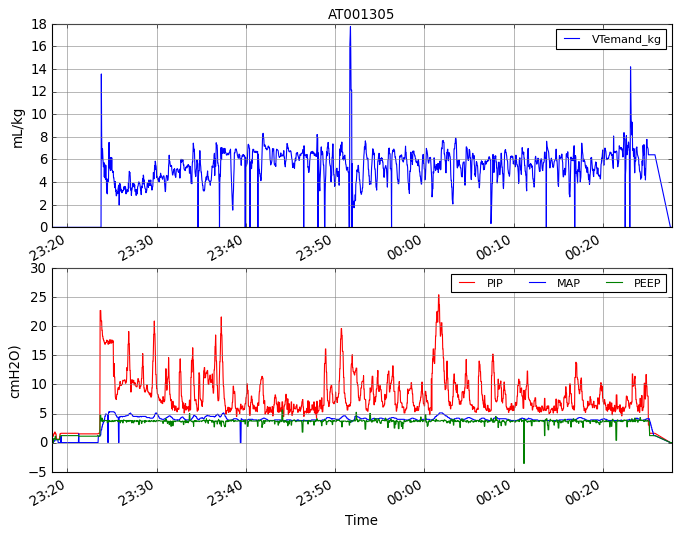

In [368]:
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax0 = fig.add_subplot(2, 1, 1)
data_pars_measurements[case]['VTemand_kg'].plot(x_compat = True)
ax0.get_xaxis().set_visible(True)
ax0.set_ylabel('mL/kg', size = 12, color = 'black')
ax0.set_title(case,  size = 12, color = 'black')
ax0.legend(['VTemand_kg'], fontsize = 10, loc = 'best')
ax0.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax0.xaxis.set_major_formatter(majorFmt)
ax0.tick_params(which = 'both', labelsize=12)

ax1 = fig.add_subplot(2, 1, 2)
data_pars_measurements[case]['PIP'].plot(color = 'red', x_compat = True)
data_pars_measurements[case]['MAP'].plot(color = 'blue', x_compat = True)
data_pars_measurements[case]['PEEP'].plot(color = 'green', x_compat = True)
ax1.set_xlabel('Time', size = 12, color = 'black')
ax1.set_ylabel('cmH2O)', size = 12, color = 'black')
ax1.legend(['PIP','MAP', 'PEEP'], fontsize = 10, loc = 'best', ncol=3)
ax1.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.tick_params(which = 'both', labelsize=12)

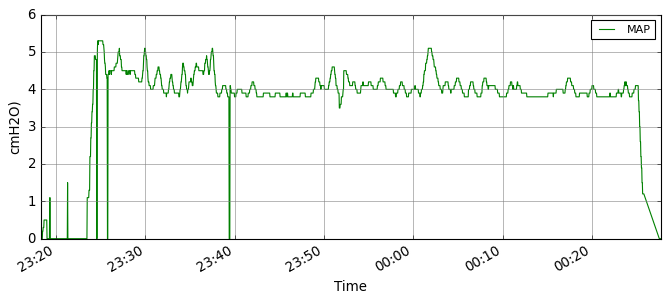

In [369]:
fig = plt.figure()
fig.set_size_inches(10, 4)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)
data_pars_measurements[case]['MAP'].plot(color = 'green', x_compat = True)
ax1.set_xlabel('Time', size = 12, color = 'black')
ax1.set_ylabel('cmH2O)', size = 12, color = 'black')
ax1.legend(['MAP', 'PEEP'], fontsize = 10, loc = 'best', ncol=3)
ax1.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.tick_params(which = 'both', labelsize=12)

In [370]:
limit[case] = eval("('%s', '%s')" % (data_pars_measurements[case].index[0], data_pars_measurements[case].index[-1]))
limit[case]

('2024-05-06 23:18:15', '2024-05-07 00:27:41')

In [376]:
limit[case] =  ('2024-05-06 23:23:45', '2024-05-07 00:25:00')

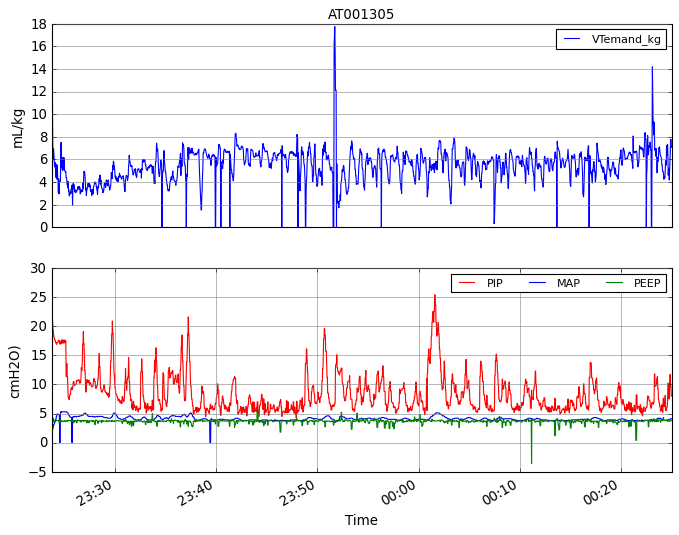

In [377]:
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax0 = fig.add_subplot(2, 1, 1)
data_pars_measurements[case]['VTemand_kg'][limit[case][0] : limit[case][1]].plot(x_compat = True)
ax0.get_xaxis().set_visible(False)
ax0.set_ylabel('mL/kg', size = 12, color = 'black')
ax0.set_title(case,  size = 12, color = 'black')
ax0.legend(['VTemand_kg'], fontsize = 10, loc = 'best')
ax0.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax0.xaxis.set_major_formatter(majorFmt)
ax0.tick_params(which = 'both', labelsize=12)

ax1 = fig.add_subplot(2, 1, 2)
data_pars_measurements[case]['PIP'][limit[case][0] : limit[case][1]].plot(color = 'red', x_compat = True)
data_pars_measurements[case]['MAP'][limit[case][0] : limit[case][1]].plot(color = 'blue', x_compat = True)
data_pars_measurements[case]['PEEP'][limit[case][0] : limit[case][1]].plot(color = 'green', x_compat = True)
ax1.set_xlabel('Time', size = 12, color = 'black')
ax1.set_ylabel('cmH2O)', size = 12, color = 'black')
ax1.legend(['PIP','MAP', 'PEEP'], fontsize = 10, loc = 'best', ncol=3)
ax1.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.tick_params(which = 'both', labelsize=12)

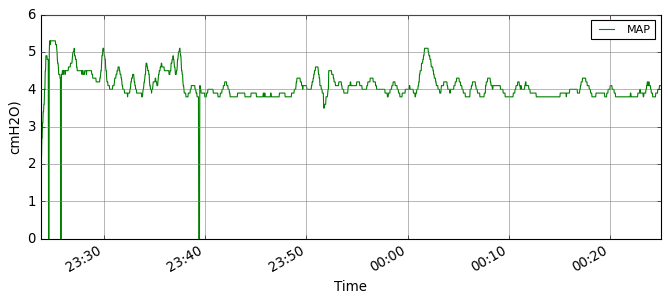

In [378]:
fig = plt.figure()
fig.set_size_inches(10, 4)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax1 = fig.add_subplot(1, 1, 1)
data_pars_measurements[case]['MAP'][limit[case][0] : limit[case][1]].plot(color = 'green', x_compat = True)
ax1.set_xlabel('Time', size = 12, color = 'black')
ax1.set_ylabel('cmH2O)', size = 12, color = 'black')
ax1.legend(['MAP', 'PEEP'], fontsize = 10, loc = 'best', ncol=3)
ax1.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.tick_params(which = 'both', labelsize=12)

KeyError: 'VThf_emand_kg'

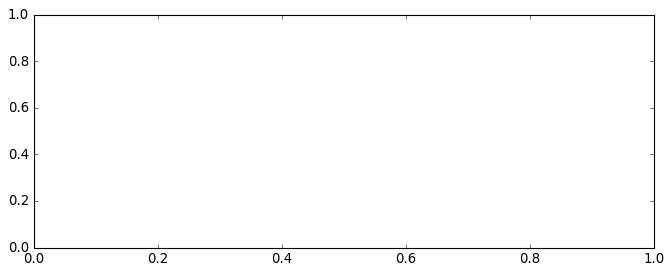

In [379]:
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=None)

ax0 = fig.add_subplot(2, 1, 1)
data_pars_measurements[case]['VThf_emand_kg'].plot()
#ax0.get_xaxis().set_visible(False)
ax0.set_ylabel('mL/kg', size = 12, color = 'black')
ax0.set_title(case,  size = 12, color = 'black')
ax0.legend(['VThf_emand_kg'], fontsize = 10, loc = 'best')
ax0.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax0.xaxis.set_major_formatter(majorFmt)
ax0.tick_params(which = 'both', labelsize=12)

ax1 = fig.add_subplot(2, 1, 2)
data_pars_measurements[case]['deltaP'].plot(color = 'red')
ax1.set_xlabel('Time', size = 12, color = 'black')
ax1.set_ylabel('cmH2O)', size = 12, color = 'black')

ax1.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.tick_params(which = 'both', labelsize=12)
ax1.set_ylim(0,70)

KeyError: 'VThf_emand_kg'

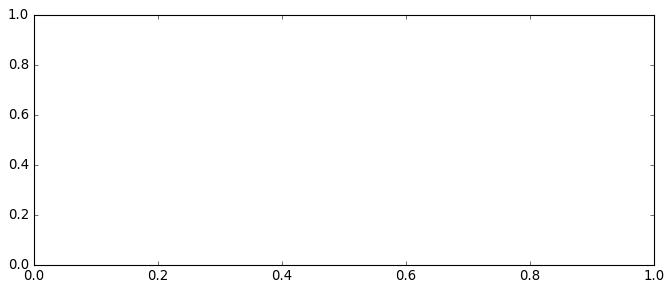

In [381]:
fig = plt.figure()
fig.set_size_inches(10, 8)
fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.05)

ax0 = fig.add_subplot(2, 1, 1)
data_pars_measurements[case]['VThf_emand_kg'][limit[case][0] : limit[case][1]].plot()
#ax0.get_xaxis().set_visible(False)
ax0.set_ylabel('mL/kg', size = 12, color = 'black')
ax0.set_title(case,  size = 12, color = 'black')
ax0.legend(['VThf_kg'], fontsize = 10, loc = 'best')
ax0.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax0.xaxis.set_major_formatter(majorFmt)
ax0.tick_params(which = 'both', labelsize=12)

ax1 = fig.add_subplot(2, 1, 2)
data_pars_measurements[case]['deltaP'][limit[case][0] : limit[case][1]].plot(color = 'red')
ax1.set_xlabel('Time', size = 12, color = 'black')
ax1.set_ylabel('cmH2O)', size = 12, color = 'black')
ax1.legend(['deltaP'], fontsize = 10, loc = 'best')
ax1.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
majorFmt = dates.DateFormatter('%H:%M')
ax1.xaxis.set_major_formatter(majorFmt)
ax1.tick_params(which = 'both', labelsize=12)

In [382]:
with open(os.path.join(DATA_DUMP, 'limit_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(limit, handle, protocol=pickle.HIGHEST_PROTOCOL)

#### Trim ventilator data using the manual filters

In [390]:
data_pars_measurements_trimmed = {}
data_pars_settings_trimmed = {}
data_pars_alarms_trimmed = {}

for case in cases:
    
    if case in limit:
        data_pars_measurements_trimmed[case] = data_pars_measurements[case][limit[case][0] : limit[case][1]]
        data_pars_settings_trimmed[case] = data_pars_settings[case][limit[case][0] : limit[case][1]]
        data_pars_alarms_trimmed[case] = data_pars_alarms[case][limit[case][0] : limit[case][1]]
        
    else:
        data_pars_measurements_trimmed[case] = data_pars_measurements[case]
        data_pars_settings_trimmed[case] = data_pars_settings[case]
        data_pars_alarms_trimmed[case] = data_pars_alarms[case]

#### Export trimmed and cleaned DataFrames

In [391]:
%%time

with open(os.path.join(DATA_DUMP, 'data_pars_measurements_trimmed_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(data_pars_measurements_trimmed, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open(os.path.join(DATA_DUMP, 'data_pars_settings_trimmed_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(data_pars_settings_trimmed, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
with open(os.path.join(DATA_DUMP, 'data_pars_alarms_trimmed_new_1_1305.pickle'), 'wb') as handle:
    pickle.dump(data_pars_alarms_trimmed, handle, protocol=pickle.HIGHEST_PROTOCOL)

CPU times: user 2.18 s, sys: 877 ms, total: 3.05 s
Wall time: 4.24 s


### 6. Exploratory analysis on ventilation modes in the trimmed recordings

In [392]:
vent_modes_trimmed = {}
for case in data_pars_settings_trimmed:
    # Multiply by two to get the number of seconds
    vent_modes_trimmed[case] = data_pars_settings_trimmed[case]['Ventilator_mode'].value_counts() * 2
    
vent_modes_trimmed = DataFrame(vent_modes_trimmed).T
vent_modes_trimmed.replace(np.nan, 0, inplace = True)

In [393]:
# Add the duration of the recordings

recording_duration_trimmed = {}

for case in data_pars_settings_trimmed:
    recording_duration_trimmed[case] = 2 * len(data_pars_settings_trimmed[case])

In [394]:
vent_modes_trimmed['ventilation'] = vent_modes_trimmed['IPPV']  + vent_modes_trimmed['SIMV'] + \
                                    vent_modes_trimmed['PSV']   + vent_modes_trimmed['HFO'] + \
                                    vent_modes_trimmed['SIPPV'] + vent_modes_trimmed['SIMVPSV']

vent_modes_trimmed['noninvasive'] = vent_modes_trimmed['CPAP']  + vent_modes_trimmed['DUOPAP'] + \
                                    vent_modes_trimmed['NCPAP'] + vent_modes_trimmed['O2therapy']  

vent_modes_trimmed['total'] = Series(recording_duration_trimmed)

In [395]:
# How long was VG turned on
VG = {}
for case in data_pars_settings_trimmed:
    VG[case] = sum(data_pars_settings_trimmed[case]['VG_state'] == 'on') * 2
        
VG = Series(VG)
vent_modes_trimmed['VG'] = VG

In [396]:
vent_modes_trimmed.head()

Ventilator_mode,CPAP,DUOPAP,HFO,IPPV,NCPAP,O2therapy,PSV,SIMV,SIMVPSV,SIPPV,ventilation,noninvasive,total,VG
AT000005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4564.0,4564.0,0.0,4564,4538
AT000006,0.0,0.0,0.0,0.0,0.0,2492.0,0.0,0.0,0.0,0.0,0.0,2492.0,2492,0
AT000007,0.0,0.0,0.0,0.0,4800.0,0.0,0.0,0.0,0.0,0.0,0.0,4800.0,4800,0
AT000008,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3102.0,0.0,0.0,3102.0,0.0,3102,3102
AT000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,650.0,0.0,4540.0,5190.0,0.0,5190,5190


In [397]:
print('SIMV:', sum(vent_modes_trimmed['SIMV'] > 0))
print('SIPPV:', sum(vent_modes_trimmed['SIPPV'] > 0))
print('SIMVPSV:', sum(vent_modes_trimmed['SIMVPSV'] > 0))
print('PSV:', sum(vent_modes_trimmed['PSV'] > 0))
print('HFO:', sum(vent_modes_trimmed['HFO'] > 0))
print('IPPV:', sum(vent_modes_trimmed['IPPV'] > 0))
print('NCPAP:', sum(vent_modes_trimmed['NCPAP'] > 0))
print('CPAP:', sum(vent_modes_trimmed['CPAP'] > 0))
print('DUOPAP:', sum(vent_modes_trimmed['DUOPAP'] > 0))
print('O2therapy:', sum(vent_modes_trimmed['O2therapy'] > 0))
print('ventilation:', sum(vent_modes_trimmed['ventilation'] > 0))
print('VG on:', sum(vent_modes_trimmed['VG'] > 0))
print('noninvasive:', sum(vent_modes_trimmed['noninvasive'] > 0))
print('total:', len(vent_modes_trimmed))

SIMV: 243
SIPPV: 214
SIMVPSV: 71
PSV: 7
HFO: 74
IPPV: 13
NCPAP: 440
CPAP: 33
DUOPAP: 100
O2therapy: 97
ventilation: 494
VG on: 405
noninvasive: 593
total: 1015


In [398]:
# How many seconds of each ventilation mode in total ?
total_duration_trimmed = DataFrame(vent_modes_trimmed.sum(axis = 0), columns = ['duration (seconds)'])
total_duration_trimmed

,duration (seconds)
Ventilator_mode,
CPAP,10732.0
DUOPAP,259816.0
HFO,203474.0
IPPV,11900.0
NCPAP,1281704.0
O2therapy,299008.0
PSV,12804.0
SIMV,856522.0
SIMVPSV,225572.0


##### Export Dataframes containing ventilator modes to Excel files and pickle archives

In [399]:
writer = pd.ExcelWriter(os.path.join(DIR_WRITE, 'ventilation_modes_trimmed_new_1_1305.xlsx'))
vent_modes_trimmed.to_excel(writer, 'vent_modes')
total_duration_trimmed.to_excel(writer, 'total_duration')
writer.close()

##### Export graphs with the ventilation  modes of the trimmed recordings ventilator modes

CPU times: user 5min 36s, sys: 1min, total: 6min 37s
Wall time: 2min 22s


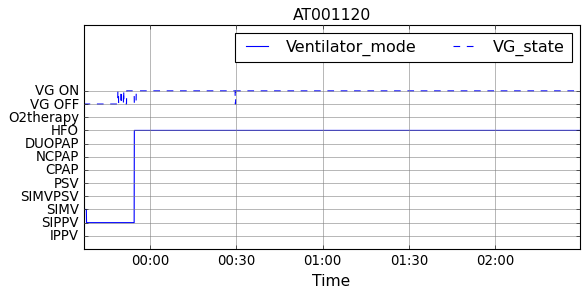

In [404]:
%%time

mapping_vent_mode = {1: 'IPPV', 2: 'SIPPV', 3: 'SIMV', 4: 'SIMVPSV', 5: 'PSV', 
                     6: 'CPAP', 7: 'NCPAP', 8: 'DUOPAP', 9: 'HFO', 10: 'O2therapy'}
mapping_vent_mode_rev = {value:key for key, value in mapping_vent_mode.items()}
mapping_vent_mode_rev

mapping_VG = {11: 'off', 12: 'on'}
mapping_VG_rev = {value:key for key, value in mapping_VG.items()}
mapping_VG_rev

par1 = 'Ventilator_mode'
par2 = 'VG_state'
dim = 'cmH$_2$O'

filetype='jpg'
dpi=200

yticks = np.arange(1, 13)
yticklabels = ['IPPV', 'SIPPV','SIMV','SIMVPSV', 'PSV', 'CPAP', 'NCPAP', 'DUOPAP', 'HFO', 'O2therapy',
              'VG OFF', 'VG ON']

for case in cases:
    #print('Saving %s' % case)
    fig = plt.figure()
    fig.set_size_inches(8, 4)
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.1)
    ax = fig.add_subplot(1, 1, 1)
        
    data = data_pars_settings[case][par1].replace(mapping_vent_mode_rev).dropna().astype('int')
    data.plot(ax = ax, label = par1, color='blue', x_compat = True)
        
    data_2 = data_pars_settings[case][par2].replace(mapping_VG_rev).dropna().astype('int')
    data_2.plot(ax = ax, label = par2, color='blue', linestyle='dashed', x_compat = True)
        
    ax.set_xlabel('Time', size = 14, color = 'black')
    ax.set_ylabel('', size = 14, color = 'black')
    ax.set_ylim(0,17)
    ax.set_yticks(yticks)
    ax.set_yticklabels(yticklabels)
    ax.set_title(case,  size = 14, color = 'black')
    ax.legend(ncols=2)
    ax.grid('on', linestyle='-', linewidth=0.5, color = 'gray')
    majorFmt = dates.DateFormatter('%H:%M')
    ax.xaxis.set_major_formatter(majorFmt)
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=0, fontsize = 12, horizontalalignment = 'center')
    ax.tick_params(which = 'both', labelsize=12)
    
    fig.savefig(os.path.join(DATA_DUMP, 'fabian_cases_new', case, f'{case}_trimmed_ventilation_mode.{filetype}'), 
        dpi = dpi, format = filetype, bbox_inches='tight', pad_inches=0.1,);
    
    if case != 'AT001120':
        plt.close()